REFERENCE PAPERS

branch mlp : https://proceedings.mlr.press/v162/peng22a.html?ref=https://githubhelp.com

sklearn : @article{scikit-learn,
  title={Scikit-learn: Machine Learning in Python},
  author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V. and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P. and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
  journal={Journal of Machine Learning Research},
  volume={12},
  pages={2825--2830},
  year={2011}
}

adding common layer : https://proceedings.nips.cc/paper/2021/file/cba0a4ee5ccd02fda0fe3f9a3e7b89fe-Paper.pdf
                      https://arxiv.org/abs/2307.00592
                      https://arxiv.org/abs/2112.04453

XGBoost: https://dl.acm.org/doi/abs/10.1145/2939672.2939785

Random forests: https://link.springer.com/article/10.1023/a:1010933404324

residual blocks : https://ar5iv.org/html/2105.03404v2
                  https://arxiv.org/abs/2107.08391

L2 regularisation : https://www.researchgate.net/publication/215721451_Neural_Networks_For_Pattern_Recognition (DOI:10.1093/oso/9780198538493.001.0001)
                    https://dl.acm.org/doi/abs/10.1145/1015330.1015435


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from load_data import process_steel_data

full_path = 'data/'
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
correlation_rate = 0.2
dvl_line = 1

df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=True)

Dropped 24 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
df['steel_family'].value_counts()

steel_family
IF      6069
HSLA    5672
CMn     3855
Name: count, dtype: int64

In [4]:
# labeling the features for each branch
features = [col for col in df.columns if col not in ['r_value', 'steel_family', 'steel_grade']]
features_dict = {
   'time': [col for col in features if 'time' in col.lower()], 
   'chemical': ['pct_al', 'pct_b', 'pct_c', 'pct_cr', 'pct_mn', 'pct_n', 'pct_nb', 'pct_si', 'pct_ti', 'pct_v', 'mfia_coil_frac_fer', 'mfia_et1_frac_fer', 'mfia_et2_frac_fer'],
   'model': ["rm", "ag", "a80", "n_value"]
}
features_dict['process'] = [col for col in features if col not in features_dict['time'] and col not in features_dict['chemical']]

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split first to avoid data leakage
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family', 'steel_grade'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family', 'steel_grade'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [6]:
class MultiBranchSteelRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, model_dim, hidden_units=64, dropout_rate=0.2):
        super().__init__()
        # Track which branches are active
        self.has_chemical = chemical_dim > 0
        self.has_time = time_dim > 0
        self.has_process = process_dim > 0
        self.has_model = model_dim > 0
        
        # Count active branches
        self.active_branches = sum([self.has_chemical, self.has_time, self.has_process, self.has_model])
        
        # Adjust hidden units for each branch
        self.branch_hidden = min(hidden_units, max(16, hidden_units // 2))
        
        # Creating branch
        def create_branch(input_dim):
            return nn.Sequential(
                nn.Linear(input_dim, self.branch_hidden),
                nn.BatchNorm1d(self.branch_hidden),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
        
        # Only create branches that have features
        if self.has_chemical:
            self.chemical_branch = create_branch(chemical_dim)
        if self.has_time:
            self.time_branch = create_branch(time_dim)
        if self.has_process:
            self.process_branch = create_branch(process_dim)
        if self.has_model:
            self.model_branch = create_branch(model_dim)
        
        # Combined input dimension based on active branches only
        combined_dim = self.branch_hidden * self.active_branches
        
        # Final layers after concatenation
        self.final_layers = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )
    
    def forward(self, chemical, time, process, model):
        features = []
        # Only process branches that have features
        if self.has_chemical:
            if chemical.dim() == 1:
                chemical = chemical.unsqueeze(0)
            features.append(self.chemical_branch(chemical))
        
        if self.has_time:
            if time.dim() == 1:
                time = time.unsqueeze(0)
            features.append(self.time_branch(time))
        
        if self.has_process:
            if process.dim() == 1:
                process = process.unsqueeze(0)
            features.append(self.process_branch(process))
        
        if self.has_model:
            if model.dim() == 1:
                model = model.unsqueeze(0)
            features.append(self.model_branch(model))
        
        # Concatenate only active features
        combined = torch.cat(features, dim=1) if len(features) > 1 else features[0]
        return self.final_layers(combined)

In [7]:
class EnhancedMultiBranchRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, model_dim=None, hyperparameters=None):
        super().__init__()

        default_params = {
            'batch_size': 32,
            'hidden_units': 64,
            'dropout_rate': 0.2,
            'cross_branch_dropout': 0,
            'final_layer_units': [128, 64],
            'final_layer_dropout': [0, 0],
            'activation': nn.ReLU(),
            'normalization': 'layer',
            'l2_lambda': 0.001,
            'residual_blocks': 2  # Number of residual blocks per branch
        }
        # Merge default and provided hyperparameters
        self.hp = {**default_params, **(hyperparameters or {})}

        def get_normalization(units):
            """Select normalization layer based on configuration."""
            if self.hp['normalization'] == 'batch':
                return nn.BatchNorm1d(units)
            elif self.hp['normalization'] == 'layer':
                return nn.LayerNorm(units)
            else:
                return nn.Identity()

        def create_residual_block(input_dim):
            """Create a residual block with adaptive configuration."""
            return ResidualBlock(
                input_dim, 
                self.hp['hidden_units'], 
                activation=self.hp['activation'], 
                dropout_rate=self.hp['dropout_rate'],
                normalization_func=get_normalization
            )

        def create_residual_branch(input_dim):
            """Create a residual branch with multiple blocks."""
            if input_dim <= 0:
                return None
            
            blocks = []
            # Initial projection layer
            blocks.append(nn.Linear(input_dim, self.hp['hidden_units']))
            blocks.append(get_normalization(self.hp['hidden_units']))
            blocks.append(self.hp['activation'])

            # Add residual blocks
            for _ in range(self.hp['residual_blocks']):
                blocks.append(create_residual_block(self.hp['hidden_units']))
            
            return nn.Sequential(*blocks)

        # Residual Branches
        self.branches = nn.ModuleDict({
            'chemical': create_residual_branch(chemical_dim),
            'time': create_residual_branch(time_dim),
            'process': create_residual_branch(process_dim),
            'model': create_residual_branch(model_dim)
        })

        # Cross-branch interaction
        active_branches = sum(1 for branch in self.branches.values() if branch is not None)
        cross_input_dim = self.hp['hidden_units'] * active_branches

        # Cross-branch interaction with residual connection
        self.cross_branch_interaction = nn.Sequential(
            nn.Linear(cross_input_dim, cross_input_dim // 2),
            self.hp['activation'],
            nn.Dropout(self.hp['cross_branch_dropout'])
        )

        # Dynamic final layers based on hyperparameters
        final_layers = []
        prev_units = cross_input_dim // 2
        for units, dropout_rate in zip(self.hp['final_layer_units'], self.hp['final_layer_dropout']):
            final_layers.extend([
                nn.Linear(prev_units, units),
                get_normalization(units),
                self.hp['activation'],
                nn.Dropout(dropout_rate)
            ])
            prev_units = units
        final_layers.append(nn.Linear(prev_units, 1))
        self.final_layers = nn.Sequential(*final_layers)

    def forward(self, chemical, time, process, model=None):
        processed_branches = []
        branch_inputs_and_names = [
            ('chemical', chemical, self.branches['chemical']),
            ('time', time, self.branches['time']),
            ('process', process, self.branches['process']),
            ('model', model, self.branches['model'])
        ]
        
        for name, input_tensor, branch in branch_inputs_and_names:
            if branch is not None and input_tensor is not None:
                processed_branches.append(branch(input_tensor))
        
        # Cross-branch interaction
        if len(processed_branches) > 1:
            cross_branch_features = torch.cat(processed_branches, dim=1)
            interaction_features = self.cross_branch_interaction(cross_branch_features)
        else:
            interaction_features = processed_branches[0]
        
        return self.final_layers(interaction_features)


# The ResidualBlock class remains unchanged
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation=nn.ReLU(), 
                 dropout_rate=0.2, normalization_func=None):
        super().__init__()
        
        # Use provided normalization function or default to Identity
        norm_func = normalization_func(hidden_dim) if normalization_func else nn.Identity()
        
        # Residual block with two linear layers
        self.block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            norm_func,
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            norm_func
        )
        
        # Shortcut connection
        if input_dim != hidden_dim:
            self.shortcut = nn.Linear(input_dim, hidden_dim)
        else:
            self.shortcut = nn.Identity()
        
        # Final activation
        self.activation = activation

    def forward(self, x):
        # Residual connection
        residual = self.shortcut(x)
        out = self.block(x)
        
        # Combine residual and transformed features
        combined = residual + out
        return self.activation(combined)

In [8]:
def train_family_models_enhanced(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    family_models = {}
    evaluation_results = {}
    batch_size = hyperparameters['batch_size']

    for family in df['steel_family'].unique():
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)

        # Initialize feature arrays and dimensions
        feature_arrays = {}
        feature_dims = {}

        # Process each feature category
        for category in ['chemical', 'time', 'process', 'model']:
            available_features = [col for col in features_dict[category] 
                                if col in family_data.columns]

            if available_features:
                # Scale each feature category independently
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
                feature_dims[category] = len(available_features)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))  # Empty array
                feature_dims[category] = 0

        # Prepare targets
        targets = family_data['r_value'].values

        # Split data
        split_data = train_test_split(
            feature_arrays['chemical'],
            feature_arrays['time'],
            feature_arrays['process'],
            feature_arrays['model'],
            targets,
            test_size=0.2,
            random_state=42
        )

        (X_train_chem, X_test_chem, X_train_time, X_test_time, 
         X_train_proc, X_test_proc, X_train_model, X_test_model, 
         y_train, y_test) = split_data

        # Convert to tensors
        train_tensors = {
            'chemical': torch.FloatTensor(X_train_chem),
            'time': torch.FloatTensor(X_train_time),
            'process': torch.FloatTensor(X_train_proc),
            'model': torch.FloatTensor(X_train_model)
        }

        test_tensors = {
            'chemical': torch.FloatTensor(X_test_chem),
            'time': torch.FloatTensor(X_test_time),
            'process': torch.FloatTensor(X_test_proc),
            'model': torch.FloatTensor(X_test_model)
        }

        y_train_tensor = torch.FloatTensor(y_train)
        y_test_tensor = torch.FloatTensor(y_test)

        # Create DataLoader
        train_dataset = TensorDataset(
            train_tensors['chemical'],
            train_tensors['time'],
            train_tensors['process'],
            train_tensors['model'],
            y_train_tensor
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # Initialize model
        model = EnhancedMultiBranchRegressor(
            chemical_dim=feature_dims['chemical'],
            time_dim=feature_dims['time'],
            process_dim=feature_dims['process'],
            model_dim=feature_dims['model'],
            hyperparameters=hyperparameters  # Pass the entire hyperparameters dictionary
        )

        if use_l2:
            weight_decay = 0.001
        else:
            weight_decay = 0.0
        
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
        criterion = nn.L1Loss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_chem, batch_time, batch_proc, batch_model)
                loss = criterion(outputs, batch_targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(
                test_tensors['chemical'],
                test_tensors['time'],
                test_tensors['process'],
                test_tensors['model']
            )
            test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
            y_pred_np = y_pred.numpy().flatten()
            r2 = r2_score(y_test, y_pred_np)
            mae = mean_absolute_error(y_test, y_pred_np)
            mse = mean_squared_error(y_test, y_pred_np)
            
            evaluation_results[family] = {
                'test_loss': test_loss,
                'r2_score': r2,
                'mae': mae,
                'mse': mse
            }
            print(f"Evaluation for {family} - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")

        family_models[family] = model

    return family_models, evaluation_results

In [9]:
def train_family_models_regular(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    family_models = {}
    evaluation_results = {}
    batch_size = hyperparameters['batch_size']

    for family in df['steel_family'].unique():
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)

        # Initialize feature arrays and dimensions
        feature_arrays = {}
        feature_dims = {}

        # Process each feature category
        for category in ['chemical', 'time', 'process', 'model']:
            available_features = [col for col in features_dict[category] 
                                if col in family_data.columns]

            if available_features:
                # Scale each feature category independently
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
                feature_dims[category] = len(available_features)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))  # Empty array
                feature_dims[category] = 0

        # Prepare targets
        targets = family_data['r_value'].values

        # Split data
        split_data = train_test_split(
            feature_arrays['chemical'],
            feature_arrays['time'],
            feature_arrays['process'],
            feature_arrays['model'],
            targets,
            test_size=0.2,
            random_state=42
        )

        (X_train_chem, X_test_chem, X_train_time, X_test_time, 
         X_train_proc, X_test_proc, X_train_model, X_test_model, 
         y_train, y_test) = split_data

        # Convert to tensors
        train_tensors = {
            'chemical': torch.FloatTensor(X_train_chem),
            'time': torch.FloatTensor(X_train_time),
            'process': torch.FloatTensor(X_train_proc),
            'model': torch.FloatTensor(X_train_model)
        }

        test_tensors = {
            'chemical': torch.FloatTensor(X_test_chem),
            'time': torch.FloatTensor(X_test_time),
            'process': torch.FloatTensor(X_test_proc),
            'model': torch.FloatTensor(X_test_model)
        }

        y_train_tensor = torch.FloatTensor(y_train)
        y_test_tensor = torch.FloatTensor(y_test)

        # Create DataLoader
        train_dataset = TensorDataset(
            train_tensors['chemical'],
            train_tensors['time'],
            train_tensors['process'],
            train_tensors['model'],
            y_train_tensor
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # Initialize model
        model = MultiBranchSteelRegressor(
            chemical_dim=feature_dims['chemical'],
            time_dim=feature_dims['time'],
            process_dim=feature_dims['process'],
            model_dim=feature_dims['model'],
            hidden_units=hyperparameters['hidden_units'],
            dropout_rate=hyperparameters['dropout_rate']
        )

        if use_l2:
            weight_decay = 0.001
        else:
            weight_decay = 0.0
        
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
        criterion = nn.L1Loss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_chem, batch_time, batch_proc, batch_model)
                loss = criterion(outputs, batch_targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(
                test_tensors['chemical'],
                test_tensors['time'],
                test_tensors['process'],
                test_tensors['model']
            )
            test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
            y_pred_np = y_pred.numpy().flatten()
            r2 = r2_score(y_test, y_pred_np)
            mae = mean_absolute_error(y_test, y_pred_np)
            mse = mean_squared_error(y_test, y_pred_np)
            
            evaluation_results[family] = {
                'test_loss': test_loss,
                'r2_score': r2,
                'mae': mae,
                'mse': mse
            }
            print(f"Evaluation for {family} - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")

        family_models[family] = model

    return family_models, evaluation_results

In [10]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [1e-3],
    'batch_size': [32, 64],
    'hidden_units': [64, 128],
    'dropout_rate': [0, 0.2],
    'cross_branch_dropout': [0, 0.2],
    'final_layer_units': [
        [128, 64],
        [256, 128],
    ],
    'final_layer_dropout': [
        [0, 0],
        [0.2, 0.2],
    ],
    'normalization': ['batch', 'layer']
}
grid = ParameterGrid(param_grid)

In [11]:
# from tqdm import tqdm

# num_epochs = 50

# best_results = {}
# best_params = None

# for params in tqdm(grid, desc="Grid Search Progress", leave=True):
#     print(f"\nEvaluating hyperparameters: {params}")
    
#     family_models, evaluation_results = train_family_models_enhanced(train_df, features_dict, num_epochs, params)
    
#     avg_r2 = np.mean([evaluation_results[family]['r2_score'] for family in evaluation_results])
    
#     if best_params is None or avg_r2 > best_results['avg_r2']:
#         best_results = {
#             'avg_r2': avg_r2,
#             'evaluation_results': evaluation_results
#         }
#         best_params = params

#     print(f"Average R2 Score: {avg_r2:.4f}")

# print(f"\nBest Hyperparameters: {best_params}")
# print(f"Best R2 Score: {best_results['avg_r2']:.4f}")


In [12]:
# best_results = {'avg_r2': 0.5774655195501973,
#  'evaluation_results': {'CMn': {'test_loss': 0.057762887328863144,
#    'r2_score': 0.543479086418242},
#   'HSLA': {'test_loss': 0.024983583018183708, 'r2_score': 0.718411446680632},
#   'IF': {'test_loss': 0.12141738831996918, 'r2_score': 0.47050602555171783}}}

In [13]:
best_params_grid = {'batch_size': 32,
 'cross_branch_dropout': 0,
 'dropout_rate': 0.2,
 'final_layer_dropout': [0, 0],
 'final_layer_units': [128, 64],
 'hidden_units': 64,
 'learning_rate': 0.001,
 'normalization': 'layer'}

In [14]:
best_params = {'batch_size': 32,
 'dropout_rate': 0.2,
 'hidden_units': 64,
 'learning_rate': 0.001,
 'l2_lambda': 0.001
}

In [15]:
family_models, eval_regular = train_family_models_regular(train_scaled_df, features_dict, 100, best_params, use_l2=True)

Epoch [10/100], Loss: 0.1844
Epoch [20/100], Loss: 0.1708
Epoch [30/100], Loss: 0.1672
Epoch [40/100], Loss: 0.1629
Epoch [50/100], Loss: 0.1547
Epoch [60/100], Loss: 0.1531
Epoch [70/100], Loss: 0.1478
Epoch [80/100], Loss: 0.1487
Epoch [90/100], Loss: 0.1442
Epoch [100/100], Loss: 0.1438
Evaluation for CMn - Test Loss: 0.1414, R2: 0.6807
Epoch [10/100], Loss: 0.2417
Epoch [20/100], Loss: 0.2284
Epoch [30/100], Loss: 0.2233
Epoch [40/100], Loss: 0.2130
Epoch [50/100], Loss: 0.2124
Epoch [60/100], Loss: 0.2088
Epoch [70/100], Loss: 0.1997
Epoch [80/100], Loss: 0.1981
Epoch [90/100], Loss: 0.1956
Epoch [100/100], Loss: 0.1970
Evaluation for IF - Test Loss: 0.2079, R2: 0.6258
Epoch [10/100], Loss: 0.1518
Epoch [20/100], Loss: 0.1348
Epoch [30/100], Loss: 0.1280
Epoch [40/100], Loss: 0.1203
Epoch [50/100], Loss: 0.1179
Epoch [60/100], Loss: 0.1158
Epoch [70/100], Loss: 0.1144
Epoch [80/100], Loss: 0.1122
Epoch [90/100], Loss: 0.1113
Epoch [100/100], Loss: 0.1119
Evaluation for HSLA - Test

In [16]:
def plot_actual_vs_predicted(df, family_models, features_dict):
    families = df['steel_family'].unique()
    for family in families:
        # Filter data for the current family
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)
        
        # Prepare feature arrays
        feature_arrays = {}
        for category in features_dict.keys():
            available_features = [col for col in features_dict[category]
                                  if col in family_data.columns]
            if available_features:
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))
        
        # Convert features to tensors
        input_tensors = {
            category: torch.FloatTensor(arr) for category, arr in feature_arrays.items()
        }
        
        # Make predictions
        with torch.no_grad():
            predicted = family_models[family](**input_tensors).numpy().flatten()
        
        # Get actual values
        actual = family_data['r_value'].values
        
        # Calculate metrics
        r2 = r2_score(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        
        # Create a new figure for each family
        plt.figure(figsize=(10, 8))
        
        # Scatter plot
        plt.scatter(actual, predicted, alpha=0.5)
        
        # Linear regression line
        m, b = np.polyfit(actual, predicted, 1)
        plt.plot(actual, m*actual + b, color='red', linestyle='--', label='Regression Line')
        
        # Perfect prediction line
        plt.plot([actual.min(), actual.max()], 
                 [actual.min(), actual.max()], 
                 color='green', linestyle=':', label='Perfect Prediction')
        
        # Set plot limits with buffer
        buffer = 0.2
        x_min, x_max = actual.min() - (actual.max() - actual.min()) * buffer, actual.max() + (actual.max() - actual.min()) * buffer
        y_min, y_max = predicted.min() - (predicted.max() - predicted.min()) * buffer, predicted.max() + (predicted.max() - predicted.min()) * buffer
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        # Labeling
        plt.xlabel('Actual R-value')
        plt.ylabel('Predicted R-value')
        plt.title(f'{family} Family\nR² = {r2:.4f}, MAE = {mae:.4f}')
        plt.axis('equal')
        plt.legend()
        
        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

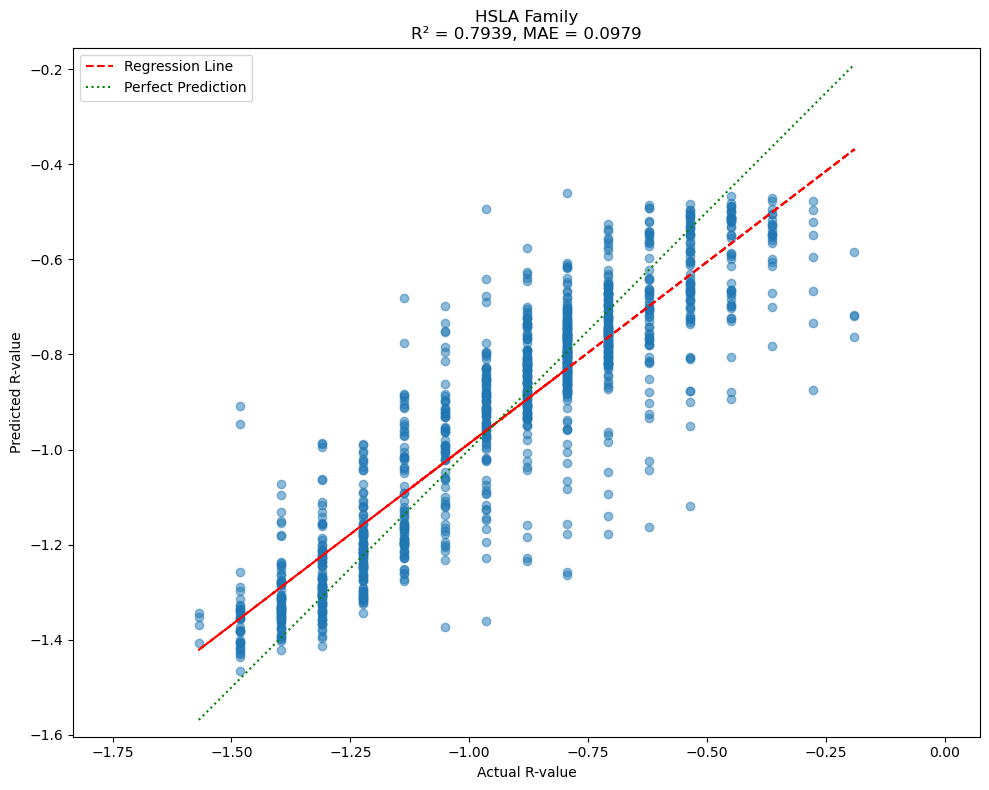

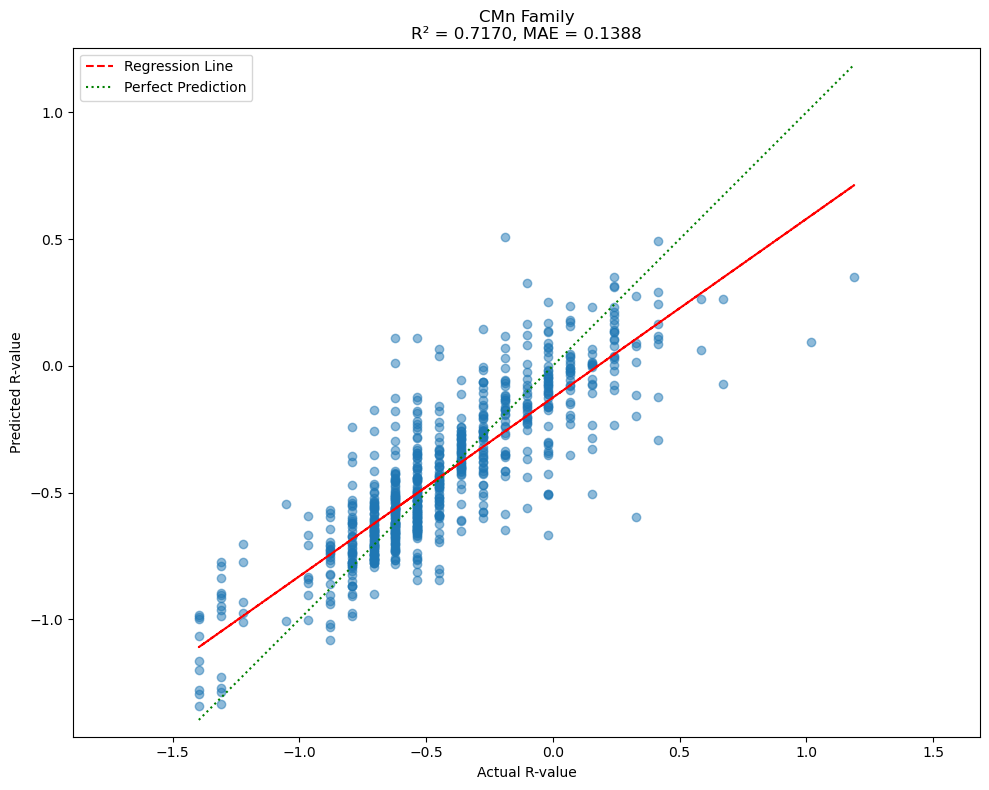

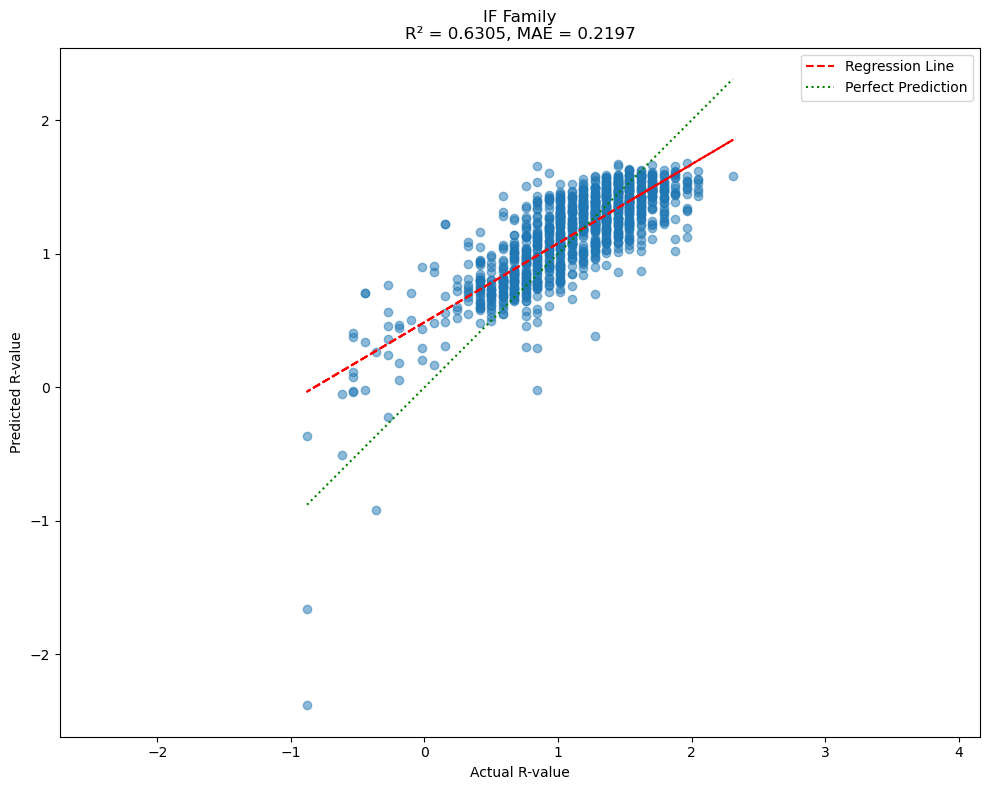

In [17]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [18]:
family_models_enhanced, eval_enhanced = train_family_models_enhanced(train_scaled_df, features_dict, 100, best_params_grid)

Epoch [10/100], Loss: 0.1435
Epoch [20/100], Loss: 0.1212
Epoch [30/100], Loss: 0.1124
Epoch [40/100], Loss: 0.1009
Epoch [50/100], Loss: 0.0943
Epoch [60/100], Loss: 0.0837
Epoch [70/100], Loss: 0.0746
Epoch [80/100], Loss: 0.0680
Epoch [90/100], Loss: 0.0634
Epoch [100/100], Loss: 0.0571
Evaluation for CMn - Test Loss: 0.1483, R2: 0.6015
Epoch [10/100], Loss: 0.2034
Epoch [20/100], Loss: 0.1834
Epoch [30/100], Loss: 0.1722
Epoch [40/100], Loss: 0.1610
Epoch [50/100], Loss: 0.1525
Epoch [60/100], Loss: 0.1408
Epoch [70/100], Loss: 0.1314
Epoch [80/100], Loss: 0.1210
Epoch [90/100], Loss: 0.1111
Epoch [100/100], Loss: 0.0996
Evaluation for IF - Test Loss: 0.2244, R2: 0.5642
Epoch [10/100], Loss: 0.1044
Epoch [20/100], Loss: 0.0941
Epoch [30/100], Loss: 0.0855
Epoch [40/100], Loss: 0.0783
Epoch [50/100], Loss: 0.0742
Epoch [60/100], Loss: 0.0720
Epoch [70/100], Loss: 0.0662
Epoch [80/100], Loss: 0.0622
Epoch [90/100], Loss: 0.0565
Epoch [100/100], Loss: 0.0544
Evaluation for HSLA - Test

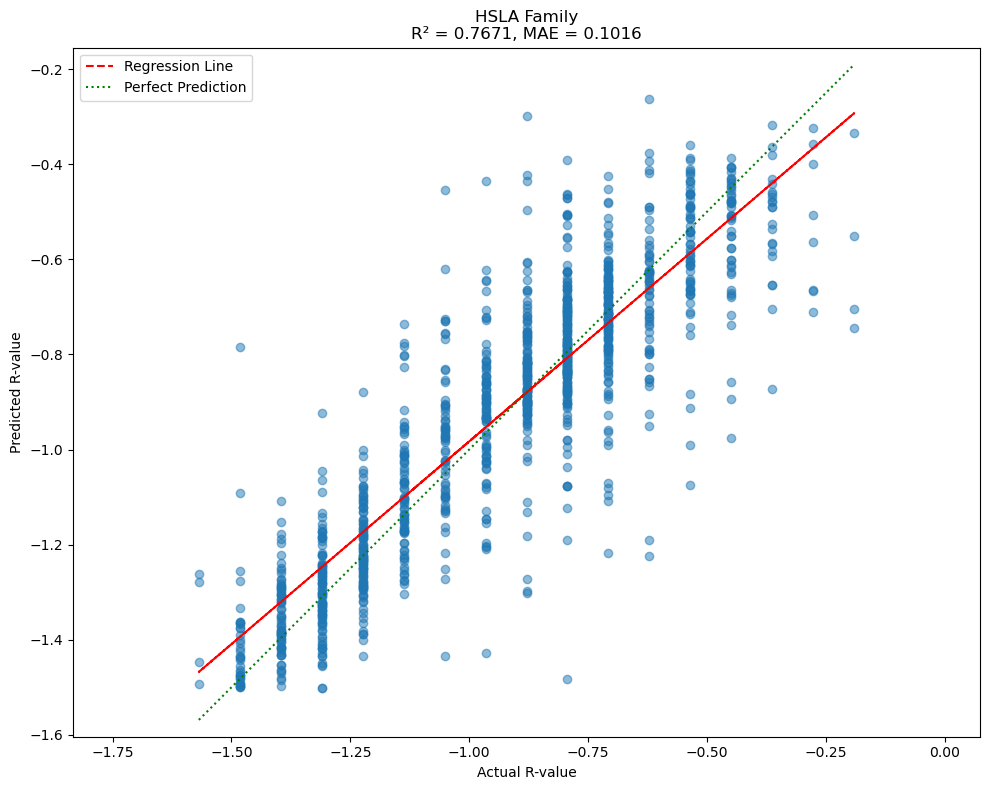

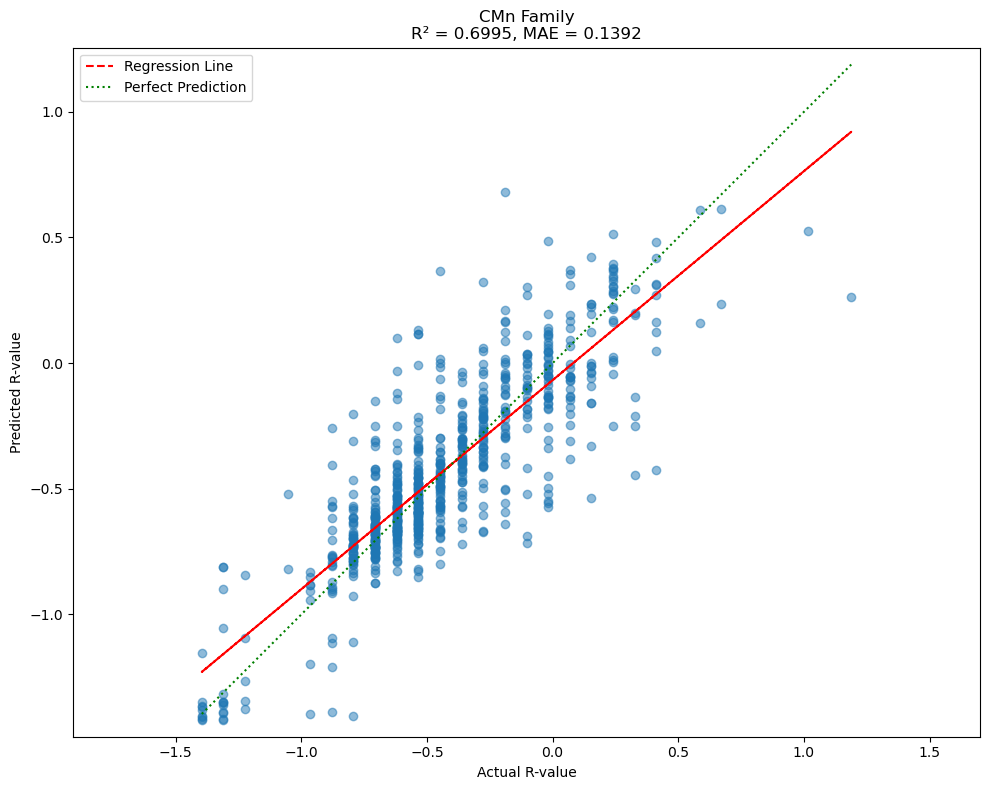

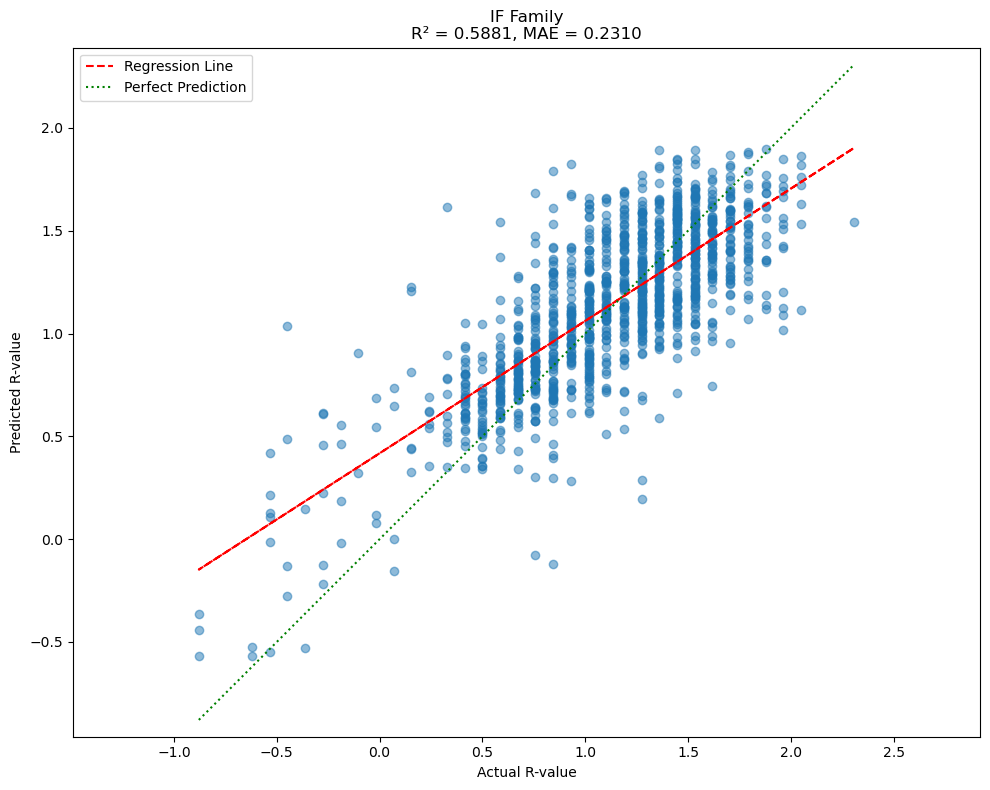

In [19]:
plot_actual_vs_predicted(test_scaled_df, family_models_enhanced, features_dict)

In [20]:
df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=False)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family', 'steel_grade'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

test_scaled = scaler.transform(test_df.drop(['steel_family', 'steel_grade'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

Dropped 24 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [21]:
family_models, eval_regular_no_model = train_family_models_regular(train_scaled_df, features_dict, 100, best_params, use_l2=True)

Epoch [10/100], Loss: 0.1966
Epoch [20/100], Loss: 0.1860
Epoch [30/100], Loss: 0.1770
Epoch [40/100], Loss: 0.1770
Epoch [50/100], Loss: 0.1687
Epoch [60/100], Loss: 0.1670
Epoch [70/100], Loss: 0.1648
Epoch [80/100], Loss: 0.1607
Epoch [90/100], Loss: 0.1619
Epoch [100/100], Loss: 0.1537
Evaluation for CMn - Test Loss: 0.1661, R2: 0.5528
Epoch [10/100], Loss: 0.2613
Epoch [20/100], Loss: 0.2547
Epoch [30/100], Loss: 0.2436
Epoch [40/100], Loss: 0.2413
Epoch [50/100], Loss: 0.2389
Epoch [60/100], Loss: 0.2363
Epoch [70/100], Loss: 0.2315
Epoch [80/100], Loss: 0.2279
Epoch [90/100], Loss: 0.2293
Epoch [100/100], Loss: 0.2229
Evaluation for IF - Test Loss: 0.2502, R2: 0.4664
Epoch [10/100], Loss: 0.1586
Epoch [20/100], Loss: 0.1394
Epoch [30/100], Loss: 0.1369
Epoch [40/100], Loss: 0.1326
Epoch [50/100], Loss: 0.1290
Epoch [60/100], Loss: 0.1256
Epoch [70/100], Loss: 0.1255
Epoch [80/100], Loss: 0.1210
Epoch [90/100], Loss: 0.1234
Epoch [100/100], Loss: 0.1166
Evaluation for HSLA - Test

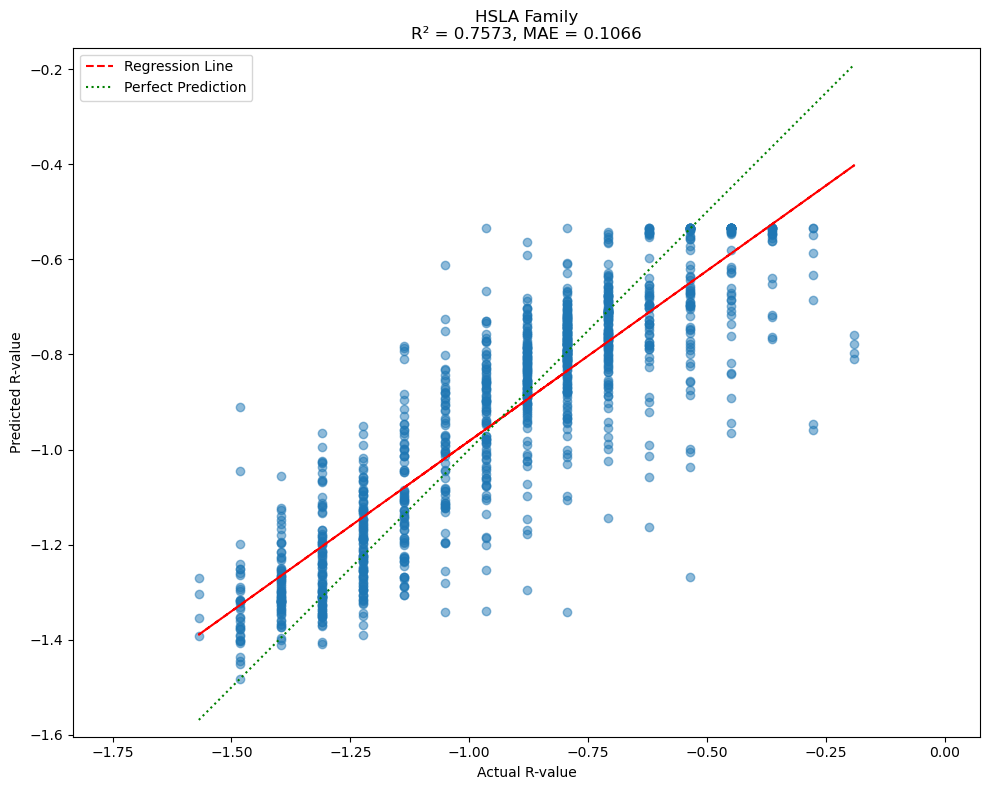

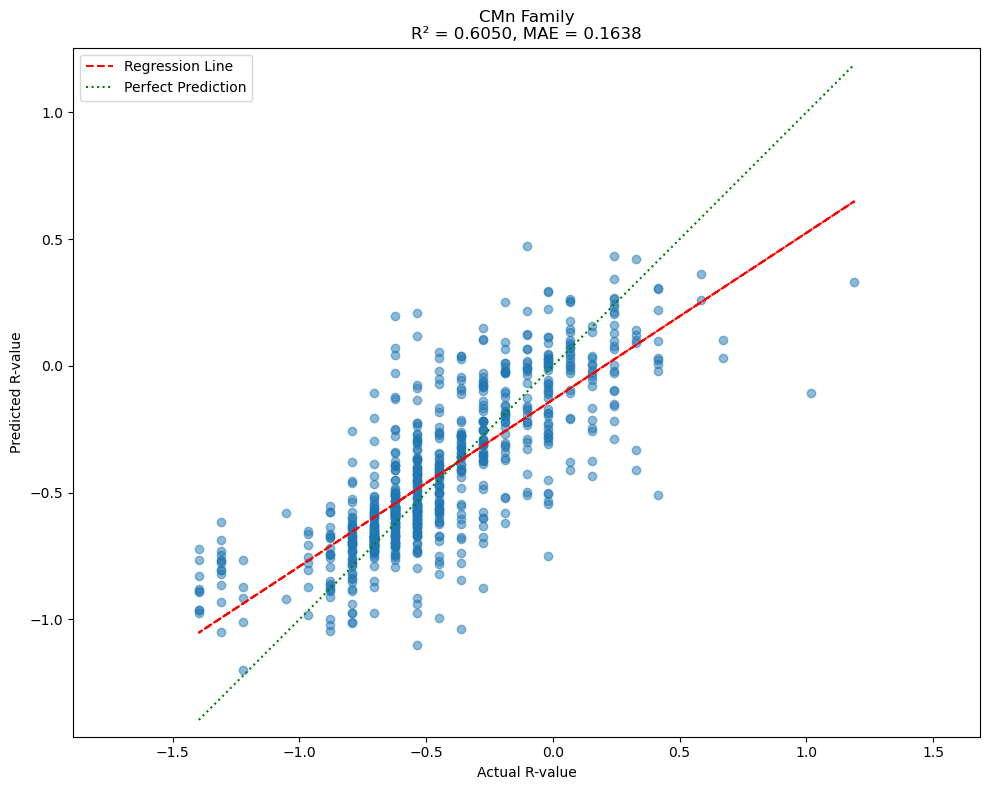

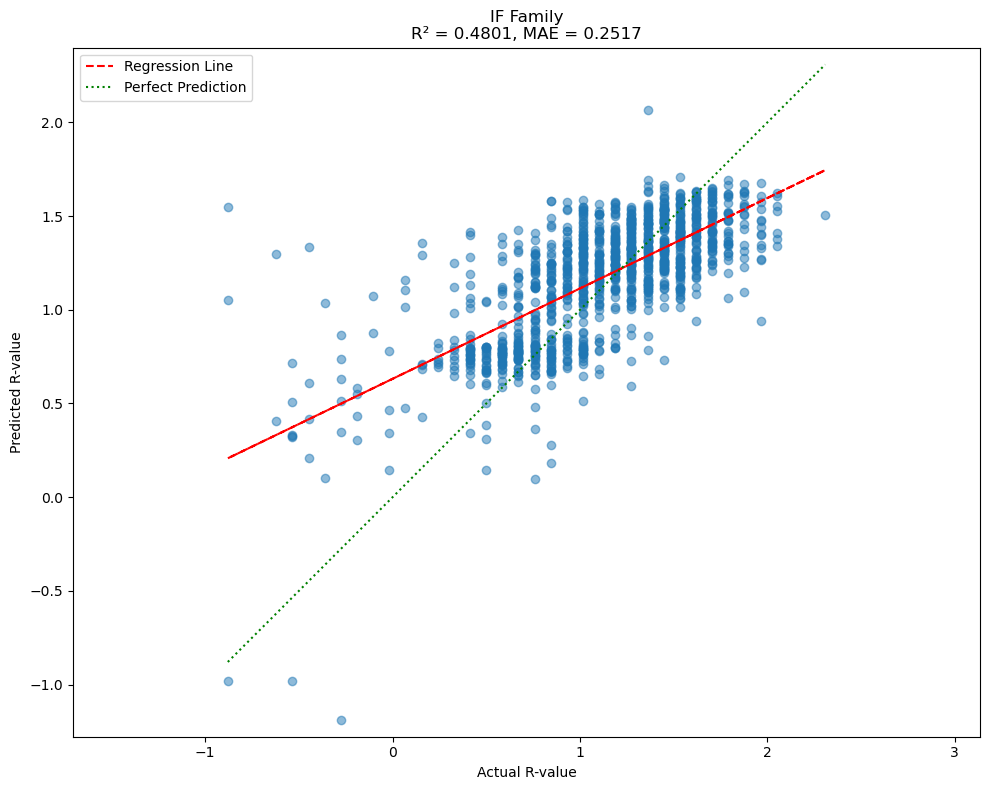

In [22]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [23]:
family_models, eval_enhanced_no_model = train_family_models_enhanced(train_scaled_df, features_dict, 100, best_params, use_l2=True)

Epoch [10/100], Loss: 0.1601
Epoch [20/100], Loss: 0.1443
Epoch [30/100], Loss: 0.1313
Epoch [40/100], Loss: 0.1222
Epoch [50/100], Loss: 0.1194
Epoch [60/100], Loss: 0.1084
Epoch [70/100], Loss: 0.0979
Epoch [80/100], Loss: 0.0948
Epoch [90/100], Loss: 0.0885
Epoch [100/100], Loss: 0.0821
Evaluation for CMn - Test Loss: 0.1769, R2: 0.4808
Epoch [10/100], Loss: 0.2286
Epoch [20/100], Loss: 0.2158
Epoch [30/100], Loss: 0.2036
Epoch [40/100], Loss: 0.1949
Epoch [50/100], Loss: 0.1841
Epoch [60/100], Loss: 0.1733
Epoch [70/100], Loss: 0.1641
Epoch [80/100], Loss: 0.1523
Epoch [90/100], Loss: 0.1402
Epoch [100/100], Loss: 0.1318
Evaluation for IF - Test Loss: 0.2566, R2: 0.4364
Epoch [10/100], Loss: 0.1118
Epoch [20/100], Loss: 0.1011
Epoch [30/100], Loss: 0.0944
Epoch [40/100], Loss: 0.0901
Epoch [50/100], Loss: 0.0839
Epoch [60/100], Loss: 0.0812
Epoch [70/100], Loss: 0.0748
Epoch [80/100], Loss: 0.0699
Epoch [90/100], Loss: 0.0647
Epoch [100/100], Loss: 0.0607
Evaluation for HSLA - Test

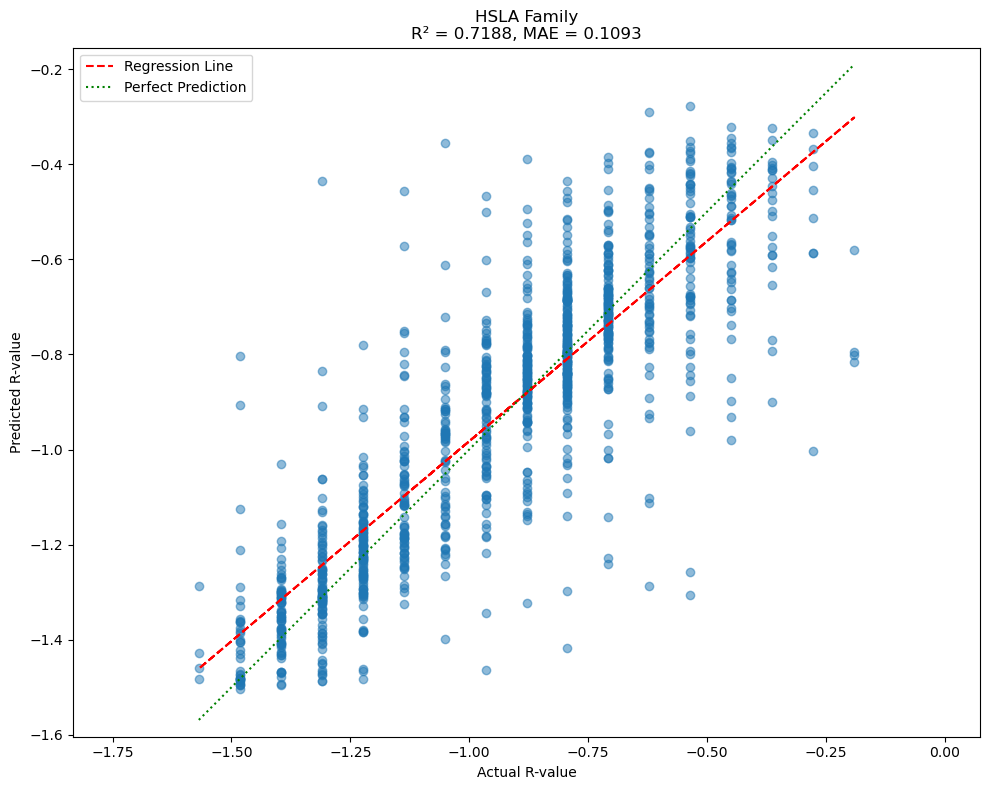

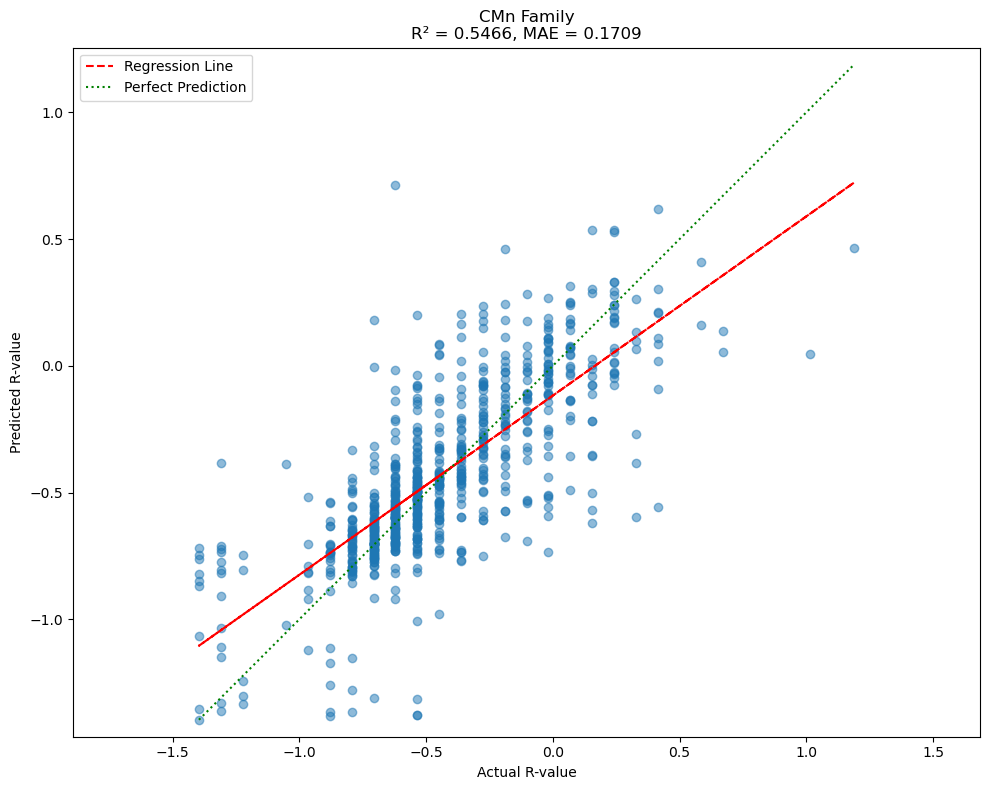

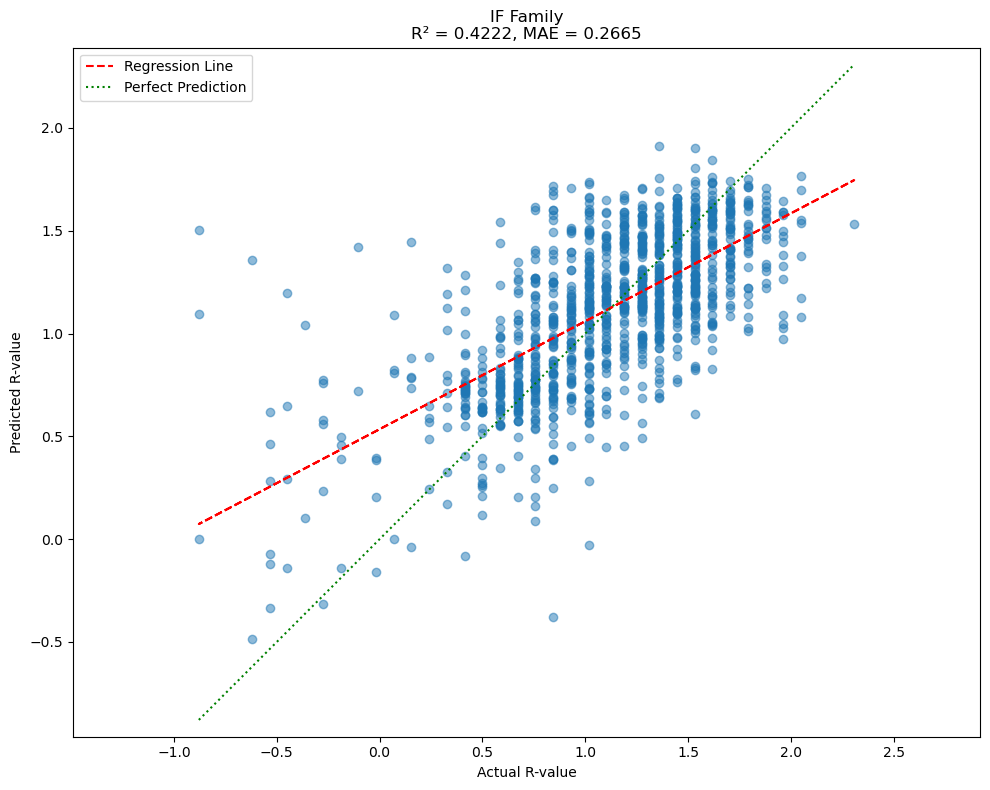

In [24]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [25]:
eval_regular_no_model

{'CMn': {'test_loss': 0.1661333590745926,
  'r2_score': 0.5527883780356793,
  'mae': 0.1661333738756599,
  'mse': 0.05794128944330363},
 'IF': {'test_loss': 0.25021669268608093,
  'r2_score': 0.46641540370238077,
  'mae': 0.2502167006738179,
  'mse': 0.10848925410929411},
 'HSLA': {'test_loss': 0.10819201171398163,
  'r2_score': 0.7282627882178392,
  'mae': 0.10819201379946979,
  'mse': 0.024247754408350926}}

In [26]:
all_models = {'regular': eval_regular, 'regular_no_model_output': eval_regular_no_model, 'enhanced': eval_enhanced, 'enhanced_no_model_output': eval_enhanced_no_model}
data = []
for model, metrics in all_models.items():
    for category, values in metrics.items():
        data.append({
            'Model': model,
            'Steel family': category,
            'r2_score': values['r2_score'],
            'Mean Absolute Error': values['mae'],
            'Mean Squared Error': values['mse']
        })
df = pd.DataFrame(data)
df

,Model,Steel family,r2_score,Mean Absolute Error,Mean Squared Error
0,regular,CMn,0.680703,0.141351,0.041369
1,regular,IF,0.625773,0.207880,0.076088
2,regular,HSLA,0.786437,0.094069,0.019057
3,regular_no_model_output,CMn,0.552788,0.166133,0.057941
4,regular_no_model_output,IF,0.466415,0.250217,0.108489
5,regular_no_model_output,HSLA,0.728263,0.108192,0.024248
6,enhanced,CMn,0.601542,0.148269,0.051625
7,enhanced,IF,0.564154,0.224429,0.088617
8,enhanced,HSLA,0.751634,0.103200,0.022162
9,enhanced_no_model_output,CMn,0.480819,0.176949,0.067266


In [33]:
df.to_csv('results_mlp.csv', index=False) 

In [40]:
csv_files = [f for f in os.listdir() if f.endswith('.csv') and f != 'merged_results.csv']

# Read and merge CSV files
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Concatenate all dataframes
merged_df = pd.concat(dataframes, ignore_index=True)

# Save the merged dataframe
merged_df.to_csv('merged_results.csv', index=False)

In [41]:
merged_df

,Model,Steel family,r2_score,Mean Absolute Error,Mean Squared Error
0,regular,CMn,0.680703,0.141351,0.041369
1,regular,IF,0.625773,0.207880,0.076088
2,regular,HSLA,0.786437,0.094069,0.019057
3,regular_no_model_output,CMn,0.552788,0.166133,0.057941
4,regular_no_model_output,IF,0.466415,0.250217,0.108489
5,regular_no_model_output,HSLA,0.728263,0.108192,0.024248
6,enhanced,CMn,0.601542,0.148269,0.051625
7,enhanced,IF,0.564154,0.224429,0.088617
8,enhanced,HSLA,0.751634,0.103200,0.022162
9,enhanced_no_model_output,CMn,0.480819,0.176949,0.067266
